C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


Saved outputs:
 - Figures: figures\phaseD\RQ2_dynamic_multiplier_cap.png, figures\phaseD\RQ2_dynamic_multiplier_cur.png, figures\phaseD\RQ2_dynamic_multiplier_cap_vs_cur.png
 - Tables : figures\tables\phaseD\RQ2_cap_params.csv, figures\tables\phaseD\RQ2_cur_params.csv, figures\tables\phaseD\RQ2_cap_impulse_summary.csv, figures\tables\phaseD\RQ2_cur_impulse_summary.csv, figures\tables\phaseD\RQ2_longrun_summary.csv
 - Diags  : figures\tables\phaseD\RQ2_diagnostics.txt
 - Meta   : figures\tables\phaseD\RQ2_run_metadata.json


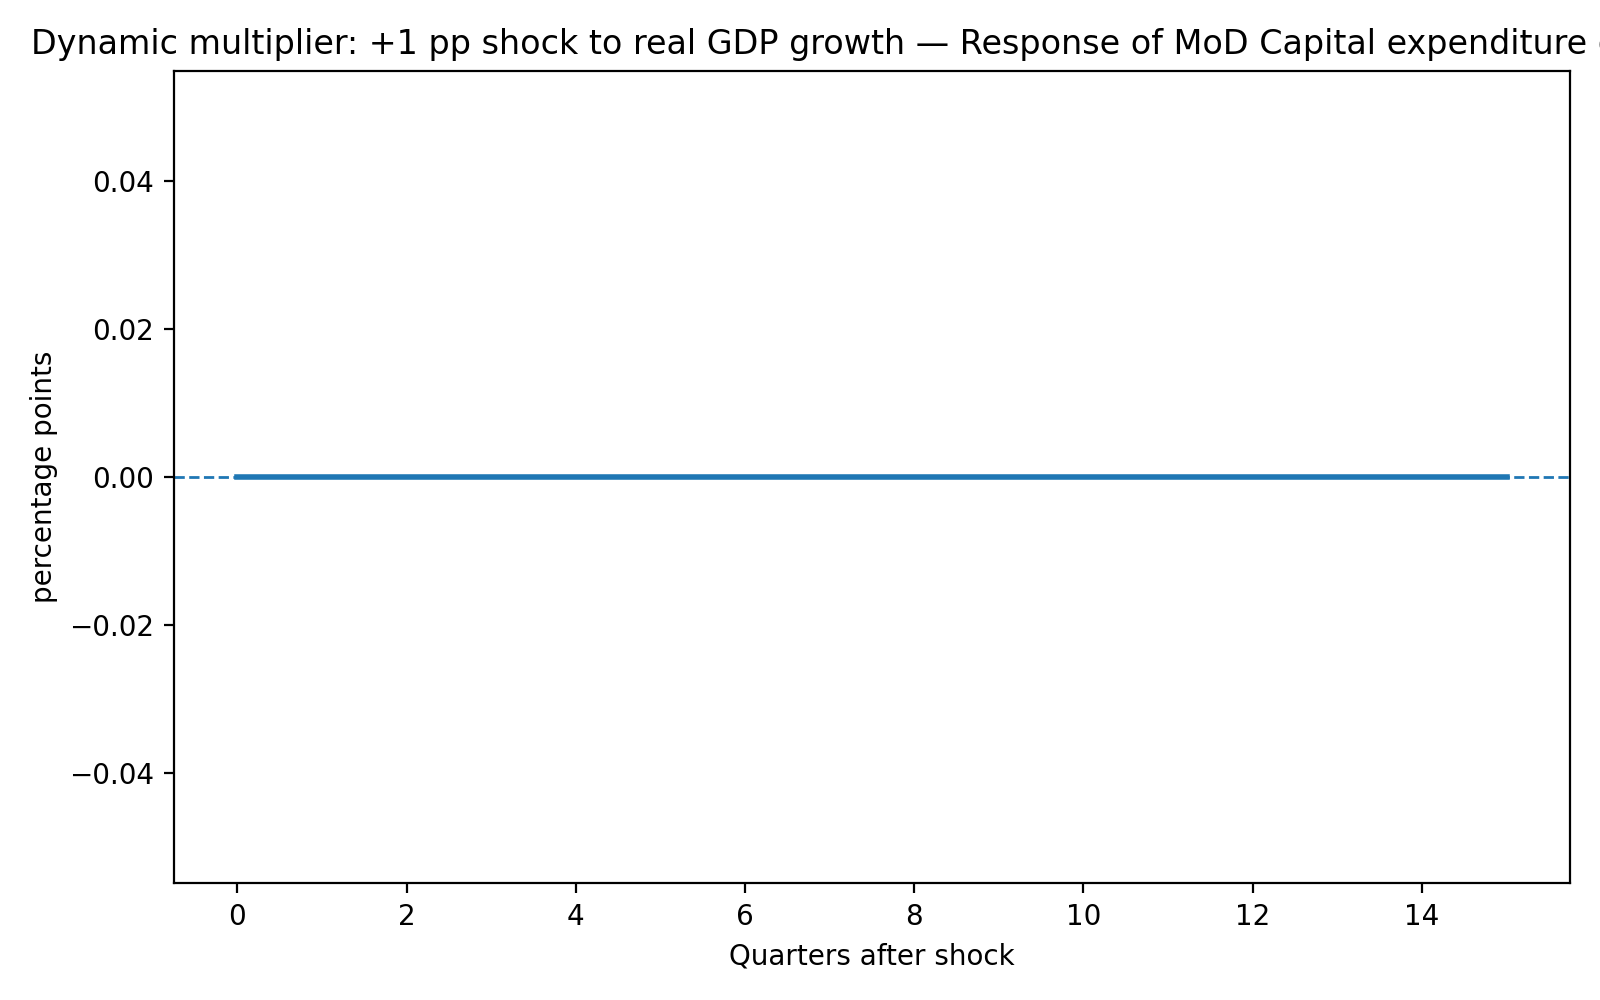

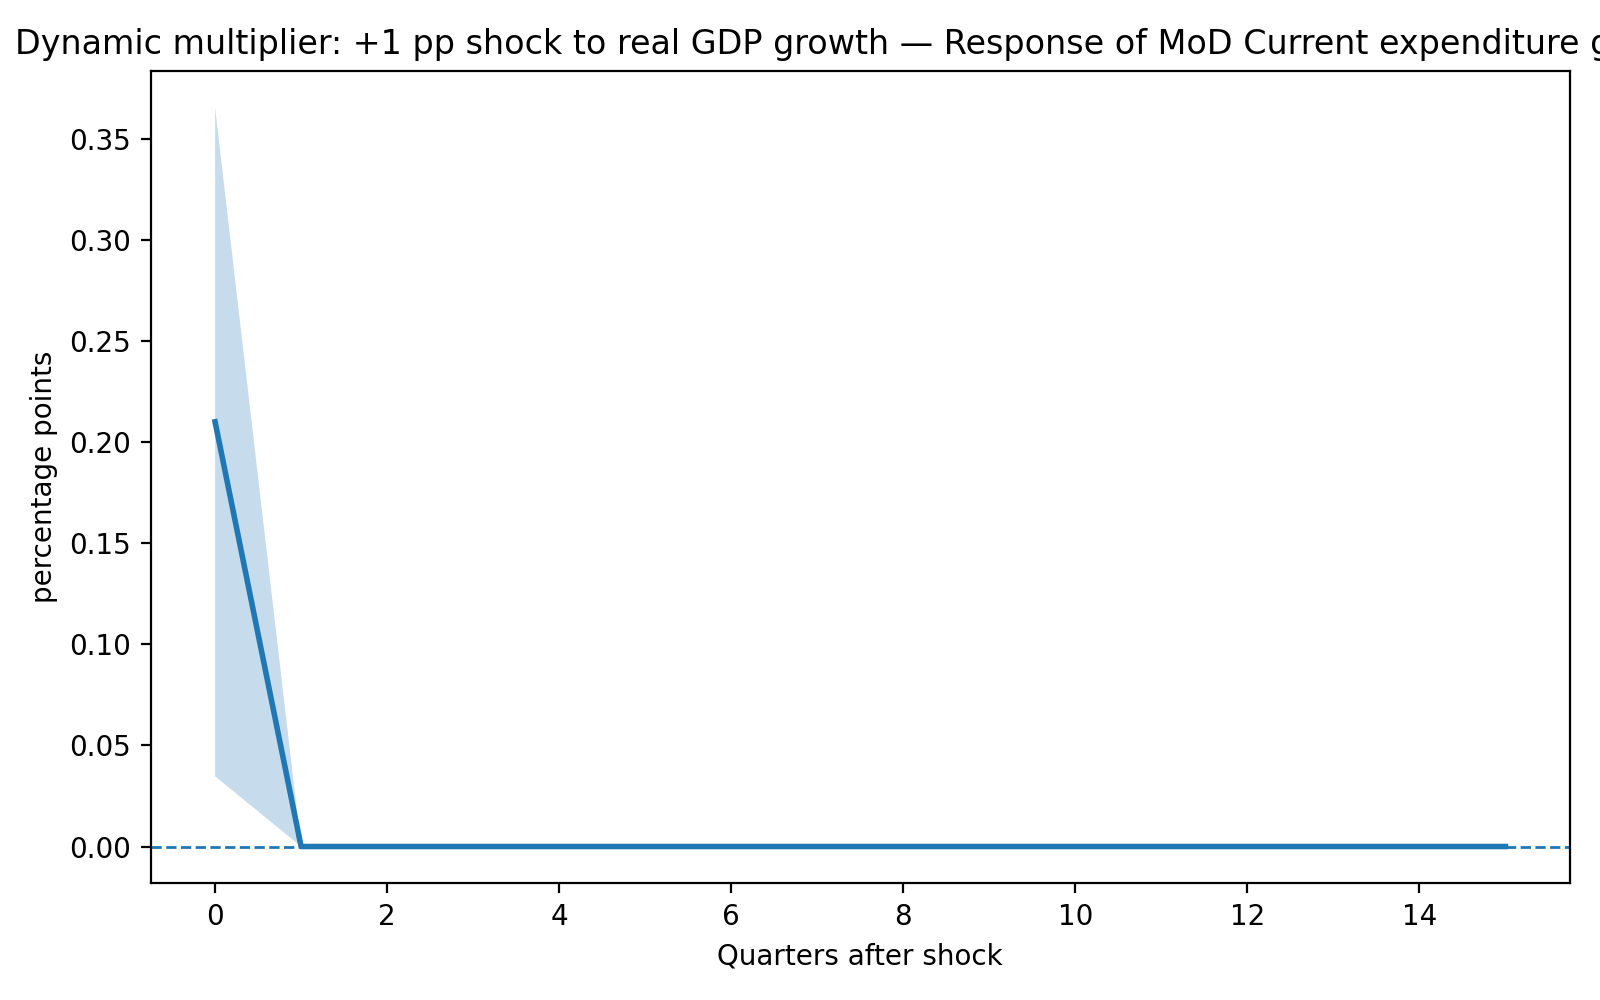

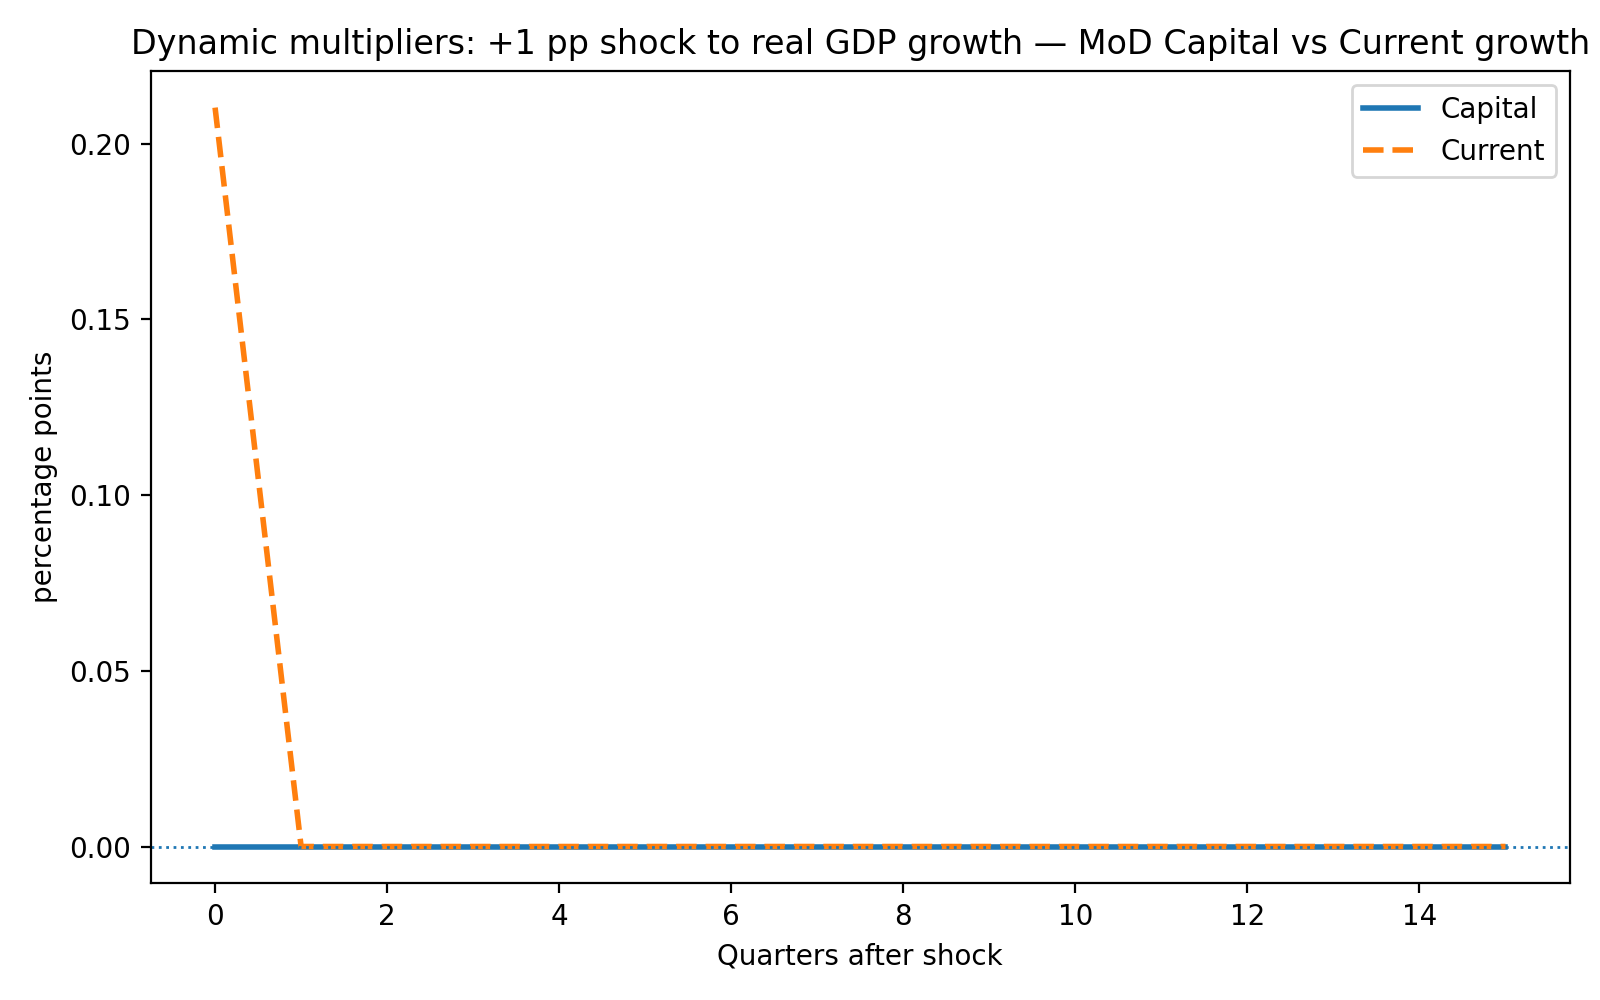

In [1]:
# ============================================================
# Phase D — RQ2 (cap_vs_cur)
# Compares MoD Capital vs Current real expenditure growth responses to a +1 pp shock in real GDP growth (2004–2024)
# Uses ardl_ready_panel.* if available; else falls back to master_panel.*; else builds from interim files you uploaded.

import os, json, warnings, re, inspect
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL, ardl_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from numpy.random import default_rng

# NEW: for inline display of saved images
from IPython.display import display, Image

warnings.filterwarnings("ignore", category=FutureWarning)
plt.close('all')

# ------------------------- Config -------------------------
SEED = 42
HORIZON = 16          # quarters in dynamic multiplier
BOOT_DRAWS = 1000     # parametric draws for CI bands
MAX_LAGS = 6          # max lag order for ARDL selection
TREND = 'c'           # include constant
START_YEAR = 2004
END_YEAR = 2024

OUT_FIG_DIR = Path("figures/phaseD")
OUT_TAB_DIR = Path("figures/tables/phaseD")
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_TAB_DIR.mkdir(parents=True, exist_ok=True)

# Candidate processed sources
PROCESSED_CANDIDATES = [
    Path("data/processed/ardl_ready_panel.parquet"),
    Path("data/processed/ardl_ready_panel.csv"),
    Path("data/processed/master_panel_phaseC_rebuild.csv"),
    Path("data/processed/master_panel_20250820.parquet"),
    Path("data/processed/master_panel_20250820.csv"),
    Path("data/processed/master_panel.csv"),
    # fallbacks to /mnt/data (uploaded)
    Path("/mnt/data/ardl_ready_panel.parquet"),
    Path("/mnt/data/ardl_ready_panel.csv"),
    Path("/mnt/data/master_panel_phaseC_rebuild.csv"),
    Path("/mnt/data/master_panel_20250820.parquet"),
    Path("/mnt/data/master_panel_20250820.csv"),
    Path("/mnt/data/master_panel.csv"),
]

# Interim fallbacks (uploaded)
INTERIM = {
    "abmi_q": Path("/mnt/data/abmi_q.csv"),
    "defence_q_wide": Path("/mnt/data/defence_q_nominal_wide.csv"),
    "cpih_q": Path("/mnt/data/cpih_quarterly.csv"),
    "ybha_q": Path("/mnt/data/ybha_q.csv"),
    "ybgb_q": Path("/mnt/data/ybgb_q.csv"),
}

# Synonyms for columns
SYN_LEVELS = {
    "gdp_real": ["gdp_real_abmi","gdp_chained_vol","gdp_cvm","abmi","abmi_q","gdp_real"],
    "mod_cap_real": ["mod_cap_real","mod_capital_real","mod_equipment_real","mod_cap_chain","mod_capital_cvm","mod_cap_cvm"],
    "mod_cur_real": ["mod_cur_real","mod_current_real","mod_personnel_opex_real","mod_current_chain","mod_current_cvm","mod_cur_cvm"],
}
SYN_GROWTH = {
    "gdp_growth": ["gdp_real_growth_q","gdp_growth_real_q","gdp_growth_q","abmi_growth_q","gdp_qoq_real_pct","gdp_real_growth","g_qoq_pct"],
    "mod_cap_growth": ["mod_cap_real_growth_q","mod_cap_growth_q","mod_cap_qoq_real_pct","mod_cap_real_growth"],
    "mod_cur_growth": ["mod_cur_real_growth_q","mod_cur_growth_q","mod_cur_qoq_real_pct","mod_cur_real_growth"],
}

# ------------------------- Helpers -------------------------
def _find_first(paths):
    for p in paths:
        if p.exists():
            return p
    return None

def _pick_column(df, names):
    cols = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in cols:
            return cols[n.lower()]
    for n in names:
        for k, orig in cols.items():
            if n.lower() in k:
                return orig
    return None

def _as_quarter_end_index_from_series(series_like) -> pd.DatetimeIndex:
    s = pd.Series(series_like).astype(str).str.strip().str.upper()
    s = s.str.replace(r"\s+", "", regex=True)
    s = s.str.replace(r"^Q([1-4])-(\d{4})$", r"\2Q\1", regex=True)
    s = s.str.replace(r"^(\d{4})-Q([1-4])$", r"\1Q\2", regex=True)
    if s.str.match(r"^\d{4}Q[1-4]$").mean() > 0.5:
        per_idx = pd.PeriodIndex(s, freq="Q")
    else:
        dt = pd.to_datetime(series_like, errors="coerce")
        per_idx = pd.PeriodIndex(dt.to_period("Q"))
    return per_idx.to_timestamp(how="end")

def _coerce_quarter_index(df):
    if isinstance(df.index, pd.PeriodIndex):
        per_idx = df.index.asfreq("Q")
        out = df.copy(); out.index = per_idx.to_timestamp(how="end"); return out
    if isinstance(df.index, pd.DatetimeIndex):
        per_idx = df.index.to_period("Q")
        out = df.copy(); out.index = per_idx.to_timestamp(how="end"); return out
    qcols = [c for c in df.columns if re.search(r"(quarter|qtr|period|time|date|yearqtr)", c, flags=re.I)]
    year_cols = [c for c in df.columns if re.fullmatch(r"year", c, flags=re.I)]
    q_only = [c for c in df.columns if re.fullmatch(r"(q|quarter)", c, flags=re.I)]
    if year_cols and q_only:
        y = pd.to_numeric(df[year_cols[0]], errors="coerce")
        q = pd.to_numeric(df[q_only[0]], errors="coerce")
        per_idx = pd.PeriodIndex(year=y.values, quarter=q.values, freq="Q")
        out = df.copy(); out.index = per_idx.to_timestamp(how="end"); return out
    if qcols:
        dt_idx = _as_quarter_end_index_from_series(df[qcols[0]])
        out = df.copy(); out.index = dt_idx; return out
    date_cols = [c for c in df.columns if re.search(r"(date|time)", c, flags=re.I)]
    if date_cols:
        dt_idx = _as_quarter_end_index_from_series(df[date_cols[0]])
        out = df.copy(); out.index = dt_idx; return out
    raise ValueError("Could not infer a quarterly time index.")

def _restrict_window(df, start_year=START_YEAR, end_year=END_YEAR):
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)].copy()

def _pct_growth(series):
    s = pd.Series(series).astype(float)
    eps = 1e-9
    s = s.replace(0, np.nan)
    return (np.log(s + eps).diff() * 100.0)

def _select_and_fit_ardl(y, x_df, max_lags=MAX_LAGS, trend=TREND):
    """Version-safe ardl_select_order; ensures exog is 2-D DataFrame."""
    assert isinstance(x_df, pd.DataFrame) and x_df.shape[1] == 1, "exog must be a single-column DataFrame"
    sig = inspect.signature(ardl_select_order)
    params = list(sig.parameters.keys())
    kwargs = {"trend": trend, "ic": "aic"}
    if "seasonal" in params: kwargs["seasonal"] = False
    kwargs.update({"endog": y, "exog": x_df, "maxlag": max_lags})
    if "maxorder" in params: kwargs["maxorder"] = max_lags
    sel = ardl_select_order(**kwargs)
    model = sel.model
    res = model.fit()
    return model, res, sel

def _extract_lag_coefs(res, y_name, x_name):
    names = list(res.params.index); vals = res.params.values
    def _lag_match(nm, var):
        m1 = re.match(rf"L(\d+)\.{re.escape(var)}$", nm)
        m2 = re.match(rf"{re.escape(var)}\.L(\d+)$", nm)
        if m1: return int(m1.group(1))
        if m2: return int(m2.group(1))
        return None
    y_pairs = [(i, _lag_match(nm, y_name)) for i, nm in enumerate(names)]
    x_pairs = [(i, _lag_match(nm, x_name)) for i, nm in enumerate(names)]
    y_pairs = [(i, l) for i,l in y_pairs if l is not None]; y_pairs.sort(key=lambda t: t[1])
    x_pairs = [(i, l) for i,l in x_pairs if l is not None]; x_pairs.sort(key=lambda t: t[1])
    phi = np.array([vals[i] for i,_ in y_pairs], dtype=float) if y_pairs else np.array([], dtype=float)
    beta = np.array([vals[i] for i,_ in x_pairs], dtype=float) if x_pairs else np.array([], dtype=float)
    return phi, beta

def _selected_lags_str_from_params(res, y_name, x_name):
    """Version-proof readable lag spec parsed from parameter names."""
    names = list(res.params.index)
    def _lags_for(var):
        lags = set()
        for nm in names:
            m1 = re.match(rf"L(\d+)\.{re.escape(var)}$", nm)
            m2 = re.match(rf"{re.escape(var)}\.L(\d+)$", nm)
            if m1: lags.add(int(m1.group(1)))
            if m2: lags.add(int(m2.group(1)))
        return sorted(lags)
    y_lags = _lags_for(y_name); x_lags = _lags_for(x_name)
    return f"{y_name}:{y_lags} | {x_name}:{x_lags}"

def _simulate_irf(phi, beta, H, shock=1.0):
    p = len(phi); q = len(beta)
    y = np.zeros(H); x = np.zeros(H); x[0] = shock
    for t in range(H):
        yt = 0.0
        for i in range(1, p+1):
            if (t - i) >= 0: yt += phi[i-1] * y[t - i]
        for j in range(0, q):
            if (t - j) >= 0: yt += beta[j] * x[t - j]
        y[t] = yt
    return y

def _bootstrap_irf(res, y_name, x_name, H=HORIZON, shock=1.0, draws=BOOT_DRAWS, seed=SEED):
    rng = default_rng(seed)
    params = res.params.values
    cov = res.cov_params()
    names = list(res.params.index)
    def _lag_match(nm, var):
        m1 = re.match(rf"L(\d+)\.{re.escape(var)}$", nm)
        m2 = re.match(rf"{re.escape(var)}\.L(\d+)$", nm)
        if m1: return int(m1.group(1))
        if m2: return int(m2.group(1))
        return None
    y_idx = [(i, _lag_match(nm, y_name)) for i, nm in enumerate(names)]
    x_idx = [(i, _lag_match(nm, x_name)) for i, nm in enumerate(names)]
    y_idx = [t for t in y_idx if t[1] is not None]; y_idx.sort(key=lambda t: t[1])
    x_idx = [t for t in x_idx if t[1] is not None]; x_idx.sort(key=lambda t: t[1])
    y_inds = [i for i,_ in y_idx]; x_inds = [i for i,_ in x_idx]
    sims = np.zeros((draws, H))
    try:
        L = np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(np.diag(np.diag(cov)))
    for d in range(draws):
        z = rng.standard_normal(size=params.shape[0])
        theta = params + L @ z
        phi_d = theta[y_inds] if len(y_inds) else np.array([])
        beta_d = theta[x_inds] if len(x_inds) else np.array([])
        sims[d, :] = _simulate_irf(phi_d, beta_d, H, shock=shock)
    return sims

def _diagnostics(residuals, x_df):
    out = {}
    for L in (4,8,12):
        lb = acorr_ljungbox(residuals, lags=[L], return_df=True)
        out[f"LjungBox_lag{L}_Q"] = float(lb['lb_stat'].iloc[0])
        out[f"LjungBox_lag{L}_p"] = float(lb['lb_pvalue'].iloc[0])
    jb = jarque_bera(residuals)
    out["JarqueBera"] = float(jb[0]); out["JB_p"] = float(jb[1])
    X = sm.add_constant(x_df, has_constant="add")
    try:
        bp = het_breuschpagan(residuals, X)
        out["BreuschPagan_LM"] = float(bp[0]); out["BP_p"] = float(bp[1])
    except Exception:
        out["BreuschPagan_LM"] = np.nan; out["BP_p"] = np.nan
    try:
        w = het_white(residuals, X)
        out["White_LM"] = float(w[0]); out["White_p"] = float(w[1])
    except Exception:
        out["White_LM"] = np.nan; out["White_p"] = np.nan
    return out

def _plot_irf(h, m, lo, hi, title, outfile, xlabel="Quarters after shock", ylabel="percentage points"):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(h, m, lw=2)
    ax.fill_between(h, lo, hi, alpha=0.25, linewidth=0)
    ax.axhline(0, lw=1, linestyle="--")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outfile, dpi=200)
    plt.close(fig)

# ------------------------- Data assembly for RQ2 -------------------------
def _load_processed_or_build():
    """
    Returns a DataFrame with columns:
    - gdp_growth      (real GDP q/q, percentage points)
    - mod_cap_growth  (real capital q/q, pp)
    - mod_cur_growth  (real current q/q, pp)
    Indexed by quarterly DateTimeIndex at quarter-end, windowed 2004–2024.
    """
    processed = _find_first(PROCESSED_CANDIDATES)
    if processed is not None:
        try:
            df = pd.read_parquet(processed) if processed.suffix == ".parquet" else pd.read_csv(processed)
        except Exception:
            if processed.suffix == ".parquet" and processed.with_suffix(".csv").exists():
                df = pd.read_csv(processed.with_suffix(".csv"))
            else:
                raise
        df = _coerce_quarter_index(df)
        gdp_g = _pick_column(df, SYN_GROWTH["gdp_growth"])
        cap_g = _pick_column(df, SYN_GROWTH["mod_cap_growth"])
        cur_g = _pick_column(df, SYN_GROWTH["mod_cur_growth"])
        if all([gdp_g, cap_g, cur_g]):
            out = df[[gdp_g, cap_g, cur_g]].copy()
            out.columns = ["gdp_growth","mod_cap_growth","mod_cur_growth"]
            return _restrict_window(out, START_YEAR, END_YEAR).dropna(how="any")
        gdp_lv = _pick_column(df, SYN_LEVELS["gdp_real"])
        cap_lv = _pick_column(df, SYN_LEVELS["mod_cap_real"])
        cur_lv = _pick_column(df, SYN_LEVELS["mod_cur_real"])
        if gdp_lv and cap_lv and cur_lv:
            tmp = pd.DataFrame({
                "gdp_growth": _pct_growth(df[gdp_lv]),
                "mod_cap_growth": _pct_growth(df[cap_lv]),
                "mod_cur_growth": _pct_growth(df[cur_lv]),
            }, index=df.index)
            tmp = _restrict_window(tmp, START_YEAR, END_YEAR)
            return tmp.dropna(how="any")
    # Build from interim uploads
    abmi = pd.read_csv(INTERIM["abmi_q"]); abmi = _coerce_quarter_index(abmi)
    gdp_g_col = _pick_column(abmi, SYN_GROWTH["gdp_growth"])
    if gdp_g_col is None:
        gdp_lv_col = _pick_column(abmi, SYN_LEVELS["gdp_real"])
        if gdp_lv_col is None: raise KeyError("ABMI file missing real GDP level/growth columns.")
        abmi["gdp_growth"] = _pct_growth(abmi[gdp_lv_col])
    else:
        abmi["gdp_growth"] = pd.to_numeric(abmi[gdp_g_col], errors="coerce")
    abmi = abmi[["gdp_growth"]]
    mod = pd.read_csv(INTERIM["defence_q_wide"]); mod = _coerce_quarter_index(mod)
    cap_nom = _pick_column(mod, ["capital"]); cur_nom = _pick_column(mod, ["current"])
    if cap_nom is None or cur_nom is None:
        raise KeyError("defence_q_nominal_wide.csv must contain 'capital' and 'current'.")
    cpih = pd.read_csv(INTERIM["cpih_q"]); cpih = _coerce_quarter_index(cpih)
    cpih_idx = _pick_column(cpih, ["cpih_idx_q","cpih_index_q","cpih_q","cpih"])
    if cpih_idx is None: raise KeyError("cpih_quarterly.csv must contain CPIH index (e.g., 'cpih_idx_q').")
    mod = mod.join(cpih[[cpih_idx]], how="left")
    denom = (mod[cpih_idx] / 100.0).replace({0: np.nan})
    mod["mod_cap_real"] = pd.to_numeric(mod[cap_nom], errors="coerce") / denom
    mod["mod_cur_real"] = pd.to_numeric(mod[cur_nom], errors="coerce") / denom
    mod["mod_cap_growth"] = _pct_growth(mod["mod_cap_real"])
    mod["mod_cur_growth"] = _pct_growth(mod["mod_cur_real"])
    mod = mod[["mod_cap_growth","mod_cur_growth"]]
    df = abmi.join(mod, how="inner")
    df = _restrict_window(df, START_YEAR, END_YEAR)
    return df.dropna(how="any")

# ------------------------- Main -------------------------
def main():
    growth = _load_processed_or_build().sort_index()
    growth = growth[["gdp_growth","mod_cap_growth","mod_cur_growth"]].dropna(how="any")

    results = {}
    diag_rows = []
    lr_rows = []

    for label, y_col, label_long in [("cap","mod_cap_growth","Capital"), ("cur","mod_cur_growth","Current")]:
        y = growth[y_col].copy()
        x_df = growth[["gdp_growth"]].copy()  # 2-D exog

        model, res, sel = _select_and_fit_ardl(y=y, x_df=x_df, max_lags=MAX_LAGS, trend=TREND)
        results[label] = (model, res, sel)

        # Save params
        pd.DataFrame({
            "param": res.params.index,
            "coef": res.params.values,
            "std_err": res.bse.values,
            "t": res.tvalues.values,
            "pval": res.pvalues.values
        }).to_csv(OUT_TAB_DIR / f"RQ2_{label}_params.csv", index=False)

        # Dynamic multiplier (shock = +1 pp to GDP growth at t=0)
        y_name = getattr(model, "endog_name", y_col)
        x_name = "gdp_growth"
        phi, beta = _extract_lag_coefs(res, y_name, x_name)
        irf = _simulate_irf(phi, beta, HORIZON, shock=1.0)
        sims = _bootstrap_irf(res, y_name, x_name, H=HORIZON, shock=1.0, draws=BOOT_DRAWS, seed=SEED)
        lo = np.percentile(sims, 5, axis=0)
        hi = np.percentile(sims, 95, axis=0)

        # Impulse summary
        pd.DataFrame({
            "horizon_q": np.arange(HORIZON),
            "response_pp": irf,
            "cum_response_pp": np.cumsum(irf),
            "lo_5": lo,
            "hi_95": hi
        }).to_csv(OUT_TAB_DIR / f"RQ2_{label}_impulse_summary.csv", index=False)

        # Long-run multiplier (sum beta)/(1 - sum phi) + CI guard
        lr_hat = np.nan
        if len(beta) > 0:
            denom = (1.0 - np.sum(phi)) if len(phi) > 0 else 1.0
            lr_hat = (np.sum(beta) / denom) if denom != 0 else np.nan

        cov = res.cov_params(); names = list(res.params.index); vals = res.params.values
        def _lag_match(nm, var):
            m1 = re.match(rf"L(\d+)\.{re.escape(var)}$", nm)
            m2 = re.match(rf"{re.escape(var)}\.L(\d+)$", nm)
            if m1: return int(m1.group(1))
            if m2: return int(m2.group(1))
            return None
        y_idx = [(i, _lag_match(nm, y_name)) for i, nm in enumerate(names)]
        x_idx = [(i, _lag_match(nm, x_name)) for i, nm in enumerate(names)]
        y_idx = [t for t in y_idx if t[1] is not None]; y_idx.sort(key=lambda t: t[1])
        x_idx = [t for t in x_idx if t[1] is not None]; x_idx.sort(key=lambda t: t[1])
        y_inds = [i for i,_ in y_idx]; x_inds = [i for i,_ in x_idx]
        rng = default_rng(SEED)
        try:
            L = np.linalg.cholesky(cov)
        except np.linalg.LinAlgError:
            L = np.linalg.cholesky(np.diag(np.diag(cov)))
        lr_sims = np.full(BOOT_DRAWS, np.nan)
        for d in range(BOOT_DRAWS):
            z = rng.standard_normal(size=vals.shape[0])
            theta = vals + L @ z
            phi_d = theta[y_inds] if len(y_inds) else np.array([])
            beta_d = theta[x_inds] if len(x_inds) else np.array([])
            denom = (1.0 - np.sum(phi_d)) if len(phi_d) else 1.0
            lr_sims[d] = (np.sum(beta_d) / denom) if (len(beta_d) and denom != 0) else np.nan
        if np.isfinite(lr_sims).any():
            lr_lo, lr_hi = np.nanpercentile(lr_sims, [5,95])
        else:
            lr_lo, lr_hi = np.nan, np.nan

        lag_spec_str = _selected_lags_str_from_params(res, y_name=y_name, x_name=x_name)

        lr_rows.append({
            "series": label_long,
            "immediate_t0": float(irf[0]),
            "cum_4q": float(np.nansum(irf[:4])),
            "cum_8q": float(np.nansum(irf[:8])),
            "long_run_hat": float(lr_hat) if np.isfinite(lr_hat) else np.nan,
            "long_run_lo5": float(lr_lo) if np.isfinite(lr_lo) else np.nan,
            "long_run_hi95": float(lr_hi) if np.isfinite(lr_hi) else np.nan,
            "selected_lags": lag_spec_str,
            "aic": float(res.aic),
            "bic": float(res.bic),
            "nobs": int(res.nobs)
        })

        # Diagnostics
        di = _diagnostics(res.resid, x_df)
        diag_rows.append({"series": label_long, **di})

        # Plot
        ttl = f"Dynamic multiplier: +1 pp shock to real GDP growth — Response of MoD {label_long} expenditure growth"
        _plot_irf(
            h=np.arange(HORIZON), m=irf, lo=lo, hi=hi,
            title=ttl,
            outfile=OUT_FIG_DIR / f"RQ2_dynamic_multiplier_{label}.png"
        )

    # Overlay CAP vs CUR
    cap_out = pd.read_csv(OUT_TAB_DIR / "RQ2_cap_impulse_summary.csv")
    cur_out = pd.read_csv(OUT_TAB_DIR / "RQ2_cur_impulse_summary.csv")
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(cap_out["horizon_q"], cap_out["response_pp"], lw=2, label="Capital")
    ax.plot(cur_out["horizon_q"], cur_out["response_pp"], lw=2, linestyle="--", label="Current")
    ax.axhline(0, lw=1, linestyle=":")
    ax.set_xlabel("Quarters after shock"); ax.set_ylabel("percentage points")
    ax.set_title("Dynamic multipliers: +1 pp shock to real GDP growth — MoD Capital vs Current growth")
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUT_FIG_DIR / "RQ2_dynamic_multiplier_cap_vs_cur.png", dpi=200)
    plt.close(fig)

    # Diagnostics table and LR summary
    diag_df = pd.DataFrame(diag_rows)
    with open(OUT_TAB_DIR / "RQ2_diagnostics.txt", "w") as f:
        f.write("=== RQ2 ARDL Residual Diagnostics (growth models) ===\n")
        f.write(diag_df.to_string(index=False))
        f.write("\n")

    lr_df = pd.DataFrame(lr_rows)
    lr_df.to_csv(OUT_TAB_DIR / "RQ2_longrun_summary.csv", index=False)

    # Metadata
    meta = {
        "window": [START_YEAR, END_YEAR],
        "horizon_q": HORIZON,
        "boot_draws": BOOT_DRAWS,
        "max_lags": MAX_LAGS,
        "trend": TREND,
        "columns_used": list(growth.columns),
    }
    with open(OUT_TAB_DIR / "RQ2_run_metadata.json", "w") as fp:
        json.dump(meta, fp, indent=2)

    # Console summary
    print("Saved outputs:")
    print(f" - Figures: {OUT_FIG_DIR/'RQ2_dynamic_multiplier_cap.png'}, {OUT_FIG_DIR/'RQ2_dynamic_multiplier_cur.png'}, {OUT_FIG_DIR/'RQ2_dynamic_multiplier_cap_vs_cur.png'}")
    print(f" - Tables : {OUT_TAB_DIR/'RQ2_cap_params.csv'}, {OUT_TAB_DIR/'RQ2_cur_params.csv'}, "
          f"{OUT_TAB_DIR/'RQ2_cap_impulse_summary.csv'}, {OUT_TAB_DIR/'RQ2_cur_impulse_summary.csv'}, {OUT_TAB_DIR/'RQ2_longrun_summary.csv'}")
    print(f" - Diags  : {OUT_TAB_DIR/'RQ2_diagnostics.txt'}")
    print(f" - Meta   : {OUT_TAB_DIR/'RQ2_run_metadata.json'}")

    # NEW: display the saved images inline in the notebook
    try:
        display(Image(filename=str(OUT_FIG_DIR / "RQ2_dynamic_multiplier_cap.png"), width=900))
        display(Image(filename=str(OUT_FIG_DIR / "RQ2_dynamic_multiplier_cur.png"), width=900))
        display(Image(filename=str(OUT_FIG_DIR / "RQ2_dynamic_multiplier_cap_vs_cur.png"), width=900))
    except Exception as e:
        print("Note: Could not display images inline:", e)

# Run
main()